# The Poisson-Bolzmann Distribution

In order to understand lubrication better, we simulate thin layers of lubricant on a metallic surface, solvated in water.
Different structures of lubricant films are created by varying parameters like their concentration and the charge of the surface.
The lubricant is somewhat solvable in water, thus parts of the film will diffuse into the bulk water.
Lubricant molecules are charged, and their distribution is roughly exponential.

As simplification, we  first create a solution of ions (Na+, purple; Cl-, green) in water (not shown).
![pic](https://i.ibb.co/Yh8DxVM/showpicture.png)

Close to the positively charged metallic surface, the electric potential (red) will be highest, falling off exponentially when further away.
This potential attracts negatively charged Chlorine ions, and pushes positively charged Natrium ions away, resulting in a higher (lower) concentration of Clorine (Natrium) near the surface.

This model fails for high potentials near the charged layer. Ions are predicted to be located abitrarily close to the surface, which is inconsistent with a finite ion radius.
This shortcoming is addressed by the Stern model:
![pic](https://upload.wikimedia.org/wikipedia/commons/f/f7/EDLC-Potentialdistribution.png)

Very close to the surface, a layer of ions is located. In this region, the potential decreases linerarly. In the rest of the liquid phase, the Poisson-Bolzmann solution holds.




In [1]:
import numpy as np
import scipy.constants as sc
import matplotlib.pyplot as plt

# Sampling and plotting
from generate_structure import generate_structure 
from generate_structure import plot_dist
from generate_structure import get_histogram
from IPython.display import Image

# Physical distribution generation
from poisson_bolzmann_distribution import debye 
from poisson_bolzmann_distribution import gamma
from poisson_bolzmann_distribution import charge_density
from poisson_bolzmann_distribution import potential

np.random.seed(74)

The Poisson-Bolzmann equation:

$
\begin{align}
\rho_{Na^+}(x) &= \rho_{Na^+}(\infty) e^{-e \Psi(x)/k_B T}\\
\Psi(x) &= \frac{2k_B T}{e} \log\Big(\frac{1 + \gamma e^{-\kappa x}}{1- \gamma e^{-\kappa x}}\Big) 
        \approx \frac{4k_B T}{e} \gamma e^{-\kappa x} \\
\gamma &= \tanh(\frac{e\Psi(0)}{4k_B T})\\
\kappa &= 1/\lambda_D\\
\lambda_D &= \Big(\frac{\epsilon \epsilon_0 k_B T}{\sum_{i} \rho_i(\infty) e^2 z_i^2} \Big)^\frac{1}{2} [m^{-1}]
\end{align}
$

## Poisson-Bolzmann Charge density $\rho(x)$

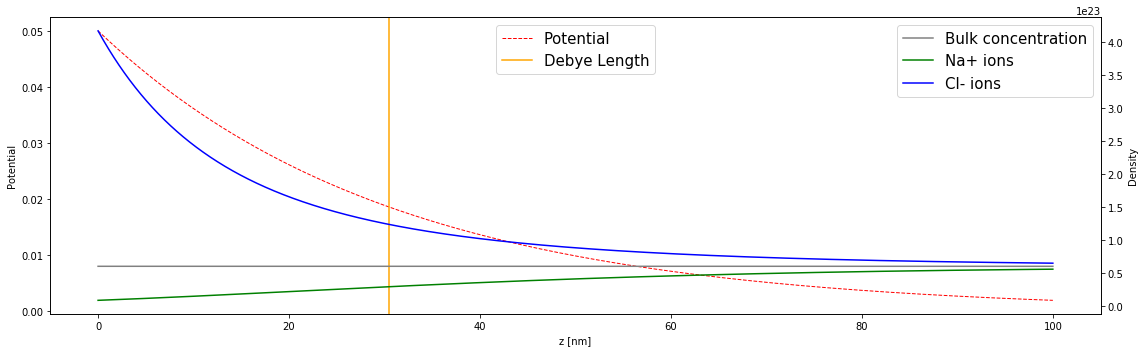

In [2]:
z = np.linspace(0, 100*10**-9, 2000)
density = sc.Avogadro * 1000 * 10**-4
rho = {'Na': density, 'Cl':density} 
charge = {'Na': 1, 'Cl': -1}
pot_0 = 0.05  # Breaks if > 1

psi = [potential(location=loc, rho_bulk=rho, charge=charge, surface_potential=pot_0) for loc in z]

rho_na = np.array([charge_density(location=loc, rho_bulk=rho, charge=charge, surface_potential=pot_0, species='Na') for loc in z])
rho_cl = np.array([charge_density(location=loc, rho_bulk=rho, charge=charge, surface_potential=pot_0, species='Cl') for loc in z])

deb = debye(rho_bulk=rho, charge=charge) * 10**9

fig, ax1 = plt.subplots(figsize=[16,5])
ax1.set_xlabel('z [nm]')
ax1.plot(z*10**9, psi, marker='', color='red', label='Potential', linewidth=1, linestyle='--')
ax1.set_ylabel('Potential')
ax1.axvline(x=deb, label='Debye Length', color='orange')

ax2 = ax1.twinx()
ax2.plot(z*10**9, [density]*len(z), label='Bulk concentration', color='grey')
ax2.plot(z*10**9, rho_na, marker='', color='green', label='Na+ ions')
ax2.plot(z*10**9, rho_cl, marker='', color='blue', label='Cl- ions')
ax2.set_ylabel('Density')

#fig.legend(loc='center')
ax2.legend(loc='best', fontsize=15)
ax1.legend(loc='upper center', fontsize=15)
fig.tight_layout()
plt.show()

The charge density behaves as expected, it interpolates between low (high) concentration and the bulk concentration within the first few debye lengths.

## Sampling
Now let's see if we can just plug our new distribution in our existing framework.

First, we need to convert the physical distribution to the format we were using so far:

In [3]:
def wrap_distribution(x, species):
    """Wrapper for na+ ions."""
    density = sc.Avogadro * 1000 * 10**-4
    rho = {'Na': density, 'Cl':density} 
    charge = {'Na': 1, 'Cl': -1}
    pot_0 = 0.05  # Breaks if > 1
    
    def call_distri(loc):
        distri = charge_density(location=loc, rho_bulk=rho, 
                                charge=charge, surface_potential=pot_0, species=species)
        return float(distri)
    
    if not np.isscalar(x):
        y = []
        for i in range(0, len(x)):
            val = call_distri(x[i])
            
            # Normalize to be 1 at x=0
            val /= call_distri(0)
            # Scale distribution to have values in [0, 0.1] for ease of sampling
            val /= 10
            y += [val]
        return np.array(y)

    # If we have only a point estimate
    val = call_distri(x)
    # Normalize to be 1 at x=0
    val /= call_distri(0)
    # Scale distribution to have values in [0, 0.1] for ease of sampling
    val /= 10    
    return val
    
def cl_distribution(x):
    return wrap_distribution(x, species='Cl')

def na_distribution(x):
    return wrap_distribution(x, species='Na')

Now we can sample the distribution of our $Na^+$ ions in z-direction.

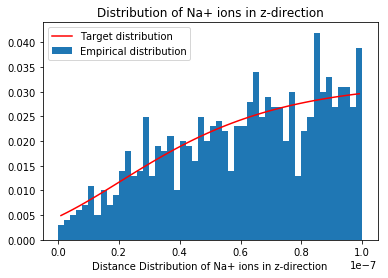

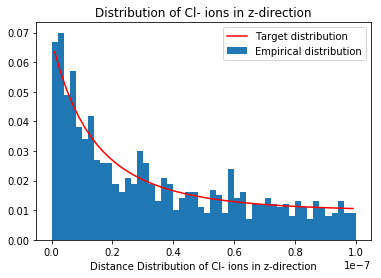

In [4]:
x = 50 * 10**-9
z = 100 * 10**-9
box = np.array([x, x, z])
sample_size = 1000

struc = generate_structure(distribution=na_distribution, box=box, atom_count=sample_size)
histx, histy, histz = get_histogram(struc, box=box, n_bins=51)
plot_dist(histz, 'Distribution of Na+ ions in z-direction', reference_distribution=na_distribution)
plt.show()

struc = generate_structure(distribution=cl_distribution, box=box, atom_count=sample_size)
histx, histy, histz = get_histogram(struc, box=box, n_bins=51)
plot_dist(histz, 'Distribution of Cl- ions in z-direction', reference_distribution=cl_distribution)
plt.show()

## Write to file
To visualize our structure, we export it to the .xyz file format, which is basically

```
ATOM_NUMBER
Optional comment
atom_type x y z
atom_type x y z
```

Avogadro expects x, y, z to be in units of $10^{-9}~m$, so we convert our salt "solution" to this unit.

Also, we use fewer atoms, just 100 for the 100x50x50 box - this will increase fluctuations with respect to the correct distribution though.

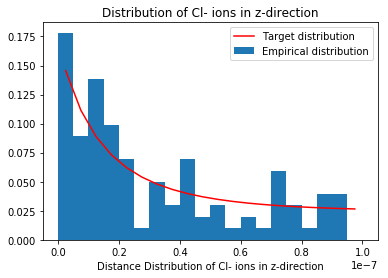

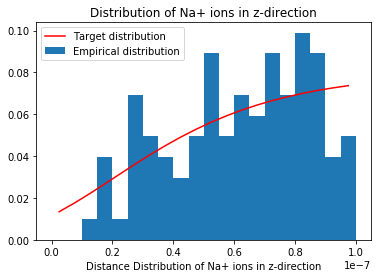

In [5]:
from generate_structure import concat_names_structs
from generate_structure import export_named_struc

cl_struc = generate_structure(distribution=cl_distribution, box=box, atom_count=100)
na_struc = generate_structure(distribution=na_distribution, box=box, atom_count=100)

concat_list = concat_names_structs(struc_list=[cl_struc, na_struc], name_list=['Cl', 'Na'])
rescaled_list = []
for line in concat_list:
    name, x, y, z = line
    x = float(x) * 10**9
    y = float(y) * 10**9
    z = float(z) * 10**9    
    rescaled_list += [[name, x, y, z]]

rescaled_list = np.array(rescaled_list)
export_named_struc(rescaled_list)

histx, histy, histz = get_histogram(cl_struc, box=box, n_bins=21)
plot_dist(histz, 'Distribution of Cl- ions in z-direction', reference_distribution=cl_distribution)

histx, histy, histz = get_histogram(na_struc, box=box, n_bins=21)
plot_dist(histz, 'Distribution of Na+ ions in z-direction', reference_distribution=na_distribution)